Found 1153 images belonging to 2 classes.
Found 287 images belonging to 2 classes.
Epoch 1/30
73/73 [==============================] - ETA: 0s - loss: 0.7050 - accuracy: 0.5533

C:\Users\KIIT\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


73/73 [==============================] - 225s 3s/step - loss: 0.7050 - accuracy: 0.5533 - val_loss: 0.6672 - val_accuracy: 0.6028
Epoch 2/30
73/73 [==============================] - 205s 3s/step - loss: 0.6827 - accuracy: 0.5924 - val_loss: 0.6607 - val_accuracy: 0.6272
Epoch 3/30
73/73 [==============================] - 207s 3s/step - loss: 0.6696 - accuracy: 0.5915 - val_loss: 0.6573 - val_accuracy: 0.6307
Epoch 4/30
73/73 [==============================] - 200s 3s/step - loss: 0.6577 - accuracy: 0.6262 - val_loss: 0.6575 - val_accuracy: 0.6272
Epoch 5/30
73/73 [==============================] - 202s 3s/step - loss: 0.6558 - accuracy: 0.6123 - val_loss: 0.6522 - val_accuracy: 0.6376
Epoch 6/30
73/73 [==============================] - 204s 3s/step - loss: 0.6492 - accuracy: 0.6262 - val_loss: 0.6498 - val_accuracy: 0.6307
Epoch 7/30
73/73 [==============================] - 203s 3s/step - loss: 0.6426 - accuracy: 0.6253 - val_loss: 0.6521 - val_accuracy: 0.6272
Epoch 8/30
73/73 [======

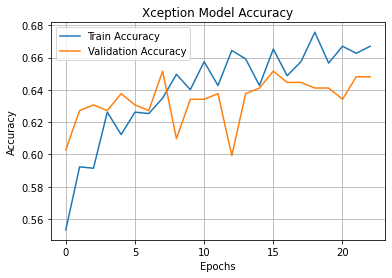

18/18 [==============================] - 48s 2s/step
Accuracy: 0.6028
Precision: 0.6179
Recall (Sensitivity): 0.8837
F1 Score: 0.7273
AUC-ROC: 0.5494
Specificity: 0.1826
K-score: 0.6028


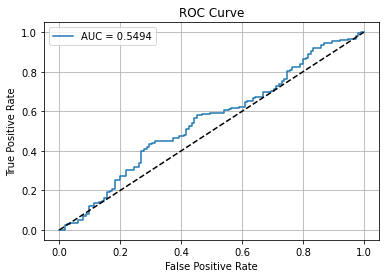

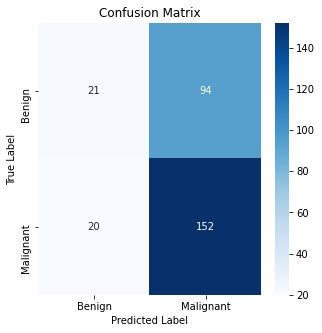

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Paths
train_data_dir = 'augmented_images'  # Contains 'benign/' and 'malignant/'

# Image parameters
img_height, img_width = 299, 299  # Required for Xception
batch_size = 16

# Data Generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

# Load Xception base model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_ckpt = ModelCheckpoint("xception_best_model.h5", monitor='val_accuracy', save_best_only=True)

# Train
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, model_ckpt]
)

# Save final model
model.save('xception_thyroid_detection_model.h5')
print("Xception Model Saved Successfully!")

# Accuracy Plot
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Xception Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Get Predictions
y_true = val_generator.classes
y_pred_prob = model.predict(val_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Compute Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)  # Sensitivity
f1 = f1_score(y_true, y_pred)
auc_roc = roc_auc_score(y_true, y_pred_prob)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn + fp)
k_score = (tp + tn) / (tp + tn + fp + fn)  # Kappa Score approximation

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"K-score: {k_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
